In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install bitsandbytes

    !git clone https://github.com/MarkusSibbesen/mechinterp_research_project.git

    if not has_changed_dir:
        os.chdir('mechinterp_research_project')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True


Running as a Colab notebook
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/12

In [2]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

from src.dataset_handling import TextDataset, TextClassificationDataset
from src.utils import get_hidden_activations, activation_label_generator
from src.sparse_autoencoders import SAE_topk
import tqdm.auto as tqdm

import json
import einops
import pandas as pd
import os
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# For the base model
url = "EleutherAI/pythia-1.4b"
hookpoints = ["gpt_neox.layers.16.mlp.act"]
out_folder = f"models/sparse_autoencoders/{url.split('/')[-1]}"
log_folder = f"training_logs/sparse_autoencoders/{url.split('/')[-1]}"

model = AutoModelForCausalLM.from_pretrained(url).to(device)
tokenizer = AutoTokenizer.from_pretrained(url)
batch_size = 32
learning_rate = 1e-3

data_path = 'data/split/tedtalks_train.tsv'
data = TextClassificationDataset.from_tsv(data_path)

dataloader = DataLoader(
    dataset=data,
    batch_size=batch_size,
    shuffle=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [4]:
# SAE data

input_size = model.config.intermediate_size

expansion_factor = 4

meta_data = {
    'input_size': input_size,
    'hidden_size': input_size * expansion_factor,
    'k': 20
}

sae = SAE_topk(meta_data=meta_data).to(device)

In [5]:
class SaeTrainer():
    def __init__(self, meta_data, learning_rate, hookpoint, device):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.hookpoint = hookpoint

        self.model = SAE_topk(meta_data).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

        self.batches = 0

        self.losses = []


    def train_step(self, input_, labels):
        outputs = self.model(input_).to(device)
        loss = self.loss_fn(outputs, labels)
        hiddens = self.model.hidden_activations
        active_neurons = len(torch.unique(hiddens.indices))
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.losses.append((loss.item(), active_neurons))
        self.batches += 1
        return loss, active_neurons

    def plot_loss(self, out_file = None):
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        losses, active_neurons = zip(*self.losses)
        ax.plot(losses, label='Loss')
        ax2 = ax.twinx()
        ax2.plot(active_neurons, label='Active neurons', color='orange')
        ax.set_xlabel('batch nr')
        ax.set_ylabel('loss')
        ax2.set_ylabel(f'active neurons per batch (batch_size: {batch_size})')
        ax.set_title(self.hookpoint)
        fig.legend()

        if out_file:
            fig.savefig(out_file, dpi=300)
        else:
            plt.show()

In [6]:
sae_trainers = [
    SaeTrainer(meta_data, learning_rate, hookpoint, device)
    for hookpoint in hookpoints
]

for activations, _ in activation_label_generator(dataloader, model, hookpoints, tokenizer, device):
    for sae_trainer in sae_trainers:
        activation = activations[sae_trainer.hookpoint]
        label = activation.detach()
        loss, active_neurons = sae_trainer.train_step(activation, label)
        print(f'{loss}\t{active_neurons}', end='')
    print('')

  0%|          | 0/2070 [00:00<?, ?it/s]

0.06859501451253891	5072
0.06474325805902481	6865
0.06321237236261368	5748
0.05908014997839928	3243
0.06108831986784935	544
0.04990922287106514	177
0.05321623012423515	147
0.044843629002571106	139
0.04592645540833473	168
0.045663490891456604	273
0.04702926054596901	202
0.045200832188129425	240
0.04515983909368515	229
0.04219865798950195	232
0.04166865348815918	321
0.043844111263751984	382
0.038536399602890015	526
0.03996738791465759	676
0.037541911005973816	719
0.03921109437942505	690
0.04392320662736893	514
0.04104907438158989	678
0.040455833077430725	859
0.037766553461551666	974
0.039505377411842346	488
0.04072273522615433	637
0.03579923138022423	607
0.036138586699962616	710
0.03749663382768631	481
0.03654536232352257	598
0.035355694591999054	498
0.03314172849059105	491
0.03423964977264404	456
0.03570844978094101	422
0.03133990243077278	307
0.03168795257806778	326
0.03419889137148857	347
0.0335732065141201	284
0.03322088345885277	274
0.031859297305345535	242
0.03177373483777046	234
0

KeyboardInterrupt: 

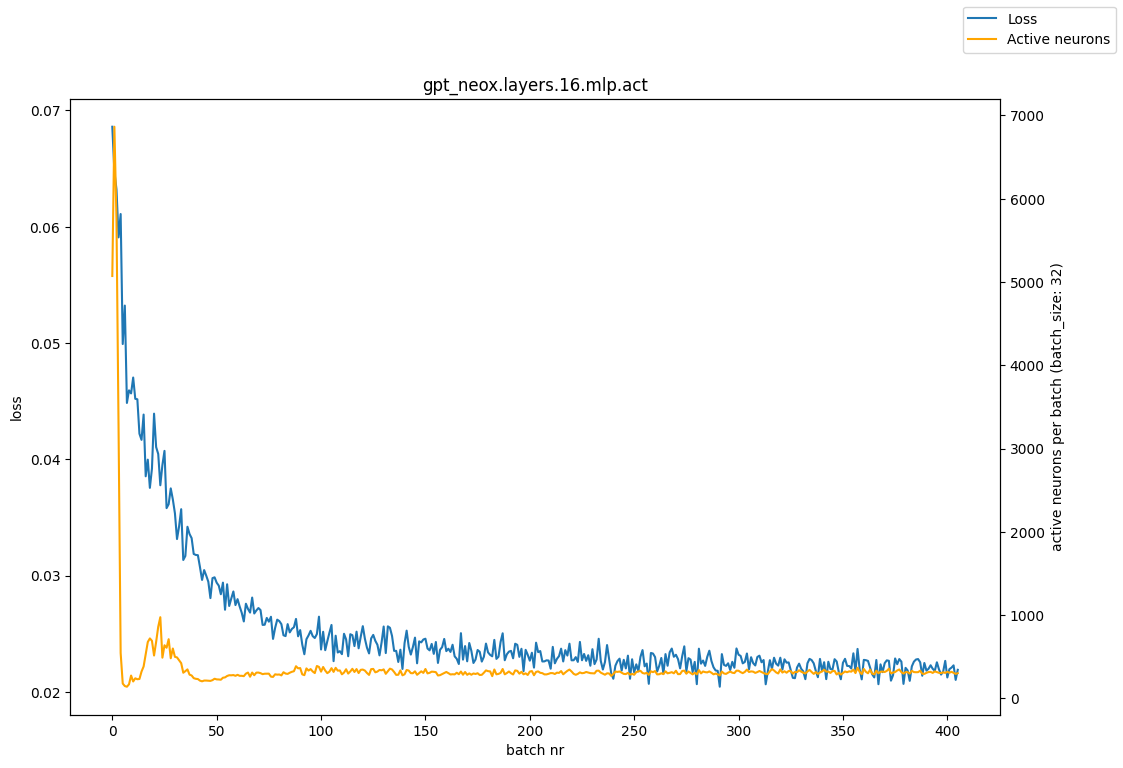

In [8]:
for sae_trainer in sae_trainers:
    hookpoint = sae_trainer.hookpoint
    k = sae_trainer.model.k

    model_out_path = f'{out_folder}/topk{k}/{hookpoint}.pt'
    meta_data_out_path = f'{out_folder}/topk{k}/{hookpoint}.json'
    log_path = f'{log_folder}/topk{k}/{hookpoint}.csv'
    log_fig_path = f'{log_folder}/topk{k}/{hookpoint}.png'


    if not os.path.isdir(f'{out_folder}'):
        os.mkdir(f'{out_folder}')
    if not os.path.isdir(f'{log_folder}'):
        os.mkdir(f'{log_folder}')

    if not os.path.isdir(f'{out_folder}/topk{k}'):
        os.mkdir(f'{out_folder}/topk{k}')
    if not os.path.isdir(f'{log_folder}/topk{k}'):
        os.mkdir(f'{log_folder}/topk{k}')

    torch.save(sae_trainer.model.state_dict(), model_out_path)

    new_meta = {key: value for key, value in meta_data.items()}
    new_meta['batch_size'] = batch_size
    new_meta['num_batches_trained_on'] = sae_trainer.batches
    new_meta['hookpoint'] = sae_trainer.hookpoint
    new_meta['learning_rate'] = learning_rate

    with open(meta_data_out_path, 'w') as file:
        json.dump(new_meta, file, indent=4)

    loss_log, active_neurons_log = zip(*sae_trainer.losses)
    df = pd.DataFrame({
        'loss': loss_log,
        'active_neurons': active_neurons_log
    })
    df.to_csv(log_path)

    sae_trainer.plot_loss(out_file=log_fig_path)

In [9]:
# too big to commit :((((